<a href="https://colab.research.google.com/github/redmodder/Real-Time-Embedded-Zone-Classification-for-Robocup-Junior-Soccer/blob/main/Zone_Classification_For_RobocupJunior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Embedded Zone Classification for Robocup Junior Soccer
## Flavio Galasso 2034377

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Import Numpy, Keras Image and MobileNetV3 libraries
import numpy as np
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report


# Extract datasets on google drive

In [ ]:
!unzip "/content/gdrive/MyDrive/Visiope Workspace/visiopedataset.zip" -d "/content/gdrive/MyDrive/Visiope Workspace/"
!unzip "/content/gdrive/MyDrive/Visiope Workspace/evaluation.zip" -d "/content/gdrive/MyDrive/Visiope Workspace/"
!unzip "/content/gdrive/MyDrive/Visiope Workspace/evaluation_easy.zip" -d "/content/gdrive/MyDrive/Visiope Workspace/"

# Setup the datagenerators

In [ ]:
IMG_DIM = 48
BATCH_SIZE = 10

data_dir = '/content/gdrive/MyDrive/Visiope Workspace/visiopedataset'
eval_dir = '/content/gdrive/MyDrive/Visiope Workspace/evaluation'
eval_easy_dir = '/content/gdrive/MyDrive/Visiope Workspace/evaluation_easy'
# this is the data loading and agumentation for the third pass, i did not save the other passes, but maybe i can get them back with colab history
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                      preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                     #brightness_range=[0.3,1.5],
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     validation_split=0.2)



train_ds = train_datagen.flow_from_directory(data_dir,target_size = (IMG_DIM,IMG_DIM), batch_size = BATCH_SIZE, subset = 'training', color_mode ="grayscale" , shuffle=True)


val_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    #rescale=1./255,
    validation_split = 0.2)
val_train_ds = val_train_datagen.flow_from_directory(data_dir,target_size = (IMG_DIM,IMG_DIM), batch_size = BATCH_SIZE, color_mode ="grayscale" , subset = 'validation', shuffle=False)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    #rescale=1./255
    )

val_ds = val_datagen.flow_from_directory(eval_dir,target_size = (IMG_DIM,IMG_DIM),  color_mode ="grayscale" ,batch_size = BATCH_SIZE, shuffle=False)

ez_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    #rescale=1./255,
    )

ez_val_ds = ez_val_datagen.flow_from_directory(eval_easy_dir,target_size = (IMG_DIM,IMG_DIM),  color_mode ="grayscale" , batch_size = BATCH_SIZE, shuffle=False)

num_samples = train_ds.n
num_classes = train_ds.num_classes
input_shape = train_ds.image_shape

classnames = [k for k,v in train_ds.class_indices.items()]
print(classnames)


Found 2332 images belonging to 9 classes.
Found 577 images belonging to 9 classes.
Found 149 images belonging to 9 classes.
Found 140 images belonging to 9 classes.
['BC', 'BL', 'BR', 'CC', 'CL', 'CR', 'TC', 'TL', 'TR']


# Let's take a look at the training and validation dataset

TRAINING SET


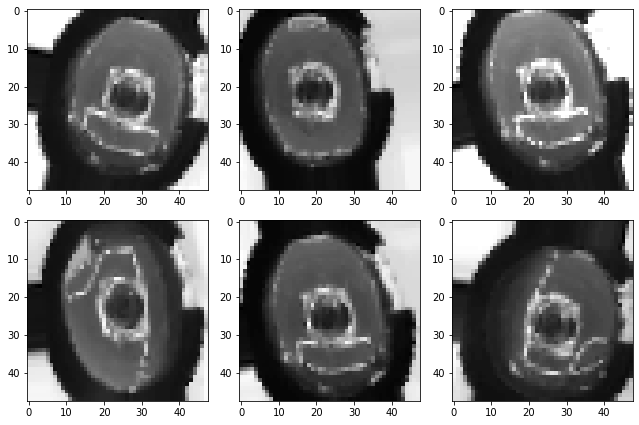

VALIDATION SET


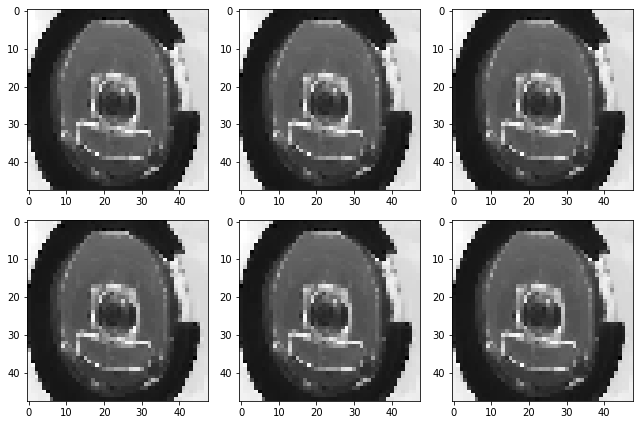

In [ ]:
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    n = 6
    num_row, num_col = 2, 3
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    
    for i in range(n):
        img = np.array(batch[0][i])
        #print(img)
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img[:,:,0], cmap='gray')
        
    plt.tight_layout()
    plt.show()

print("TRAINING SET")
visualize_batch(batch=train_ds.next())
print("VALIDATION SET")
visualize_batch(batch=val_train_ds.next())

# Optional! Agumented and processed dataset extraction
Create a ready-to-evaluate dataset for the embedded device, to save extra computational steps on the device.

In [ ]:

import os
path = '/content/gdrive/MyDrive/Visiope Workspace/rsd_dts'

for i, one_class in enumerate(os.listdir(eval_easy_dir)):
  os.mkdir(f'{path}/{one_class}')
  i = 0
  dataset = val_datagen.flow_from_directory(eval_dir,target_size = (IMG_DIM,IMG_DIM),  color_mode ="grayscale" ,batch_size = BATCH_SIZE,  
                                        class_mode = 'binary',
                                        classes = [one_class],
                                        save_to_dir = f'{path}/{one_class}',
                                        save_prefix = 'i',
                                        save_format = 'png')
  batch = next(dataset)

Found 19 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Found 53 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


## Create the base model from the pre-trained convnets

In [ ]:

IMG_SHAPE = (IMG_DIM, IMG_DIM, 1)

# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE, classes=9,
                             weights=None, alpha = 0.1, pooling=None, include_top=False)
base_model.trainable = True

"""
# Fine-tune last conv(3) + inverted_res_block_16 (8) + inverted_res_block_15,14,13 (9,9,9)
train_last_n_layers = 12
for layer in base_model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in base_model.layers[-train_last_n_layers:]:
    #print(layer)
    layer.trainable=True
"""

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.BatchNormalization()(x)
#x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 2
#x=tf.keras.layers.Dense(128,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(9,activation='softmax')(x) #final layer with softmax activation




model=tf.keras.Model(inputs=base_model.input,outputs=preds)
history_two = {'a1':[], 'a2':[], 'l1':[], 'l2':[]} #reset history
history_book = [] #reset history
model.summary()

# OPTIONAL! Model loading
Load a previously saved model weights and architecture

In [ ]:
modelname = 'NEW_model3_24E_92'
model_folder = "/content/gdrive/MyDrive/Visiope Workspace/models/"

json_file = open(model_folder+modelname+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_folder + modelname + ".h5")

model = loaded_model
history_two = {'a1':[], 'a2':[], 'l1':[], 'l2':[]} #reset history
history_book = [] #reset history
loaded_model.summary()

# Model Compiling
Uncomment the second code row for fine-tuning

In [ ]:
# compile the model
base_learning_rate = 0.001
#base_learning_rate = base_learning_rate / 100

optimizer = tf.keras.optimizers.Adam(
    learning_rate=base_learning_rate)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Model Evaluation
Can be used to see the initial state of the model or to evaluate it at any moment

In [ ]:

results = model.evaluate(val_train_ds)
results1 = model.evaluate(val_ds)
results2 = model.evaluate(ez_val_ds)

print("dataset validation split:", results)
print("hands video:",results1)
print("easy video", results2)

results = model.predict(val_train_ds)
results1 = model.predict(val_ds)
results2 = model.predict(ez_val_ds)



def plotMat(Y_pred,validation_generator):

  predicted_classes = np.argmax(Y_pred, axis=1)
  true_classes = validation_generator.classes
  class_labels = list(validation_generator.class_indices.keys())  
  print(predicted_classes)
  print(true_classes)
  print(class_labels)
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report) 
  conf = confusion_matrix(true_classes, predicted_classes)
  print(conf)
  plot_confusion_matrix(conf)

print("validation training set")
plotMat(results,val_train_ds)

print("easy validation set")
plotMat(results2,ez_val_ds)

print("hard validation set")
plotMat(results1,val_ds)





# Training!
Contains a custom callback functions that evaluates the current epoch with 2 other datasets and stops if it a configurable threshold is reached

In [ ]:

class MyMultiValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyMultiValidationCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
      global history1
      global history2
      res_eval_1 = self.model.evaluate(val_ds, verbose = 3)
      res_eval_2 = self.model.evaluate(ez_val_ds, verbose = 3)
      history_two['a1'].append(res_eval_1[1])
      history_two['l1'].append(res_eval_1[0])
      history_two['a2'].append(res_eval_2[1])
      history_two['l2'].append(res_eval_2[0])
      print("\nval loss:",res_eval_1[0], " accuracy:",res_eval_1[1])
      print("val_easy loss:",res_eval_2[0], " accuracy:",res_eval_2[1], "\n")
      if(res_eval_1[1] >= self.threshold): self.model.stop_training = True
      if(res_eval_2[1] >= self.threshold): self.model.stop_training = True
      

my_callback2 = MyMultiValidationCallback(threshold=0.95)


EPOCHS = 20
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_train_ds,
                    callbacks=[my_callback2])

history_book.append(history)

# Save the model!

In [ ]:
model_json = model.to_json()
modelname = 'NEW_model3_24E_92'
with open("/content/gdrive/MyDrive/Visiope Workspace/models/"+modelname+".json", "w") as json_file:
    json_file.write(model_json)
    model.save_weights("/content/gdrive/MyDrive/Visiope Workspace/models/"+modelname+".h5") # serialize weights to HDF5

# Metrics
shows the graph for the entire learning phase, it can sum up different .fit calls at different times

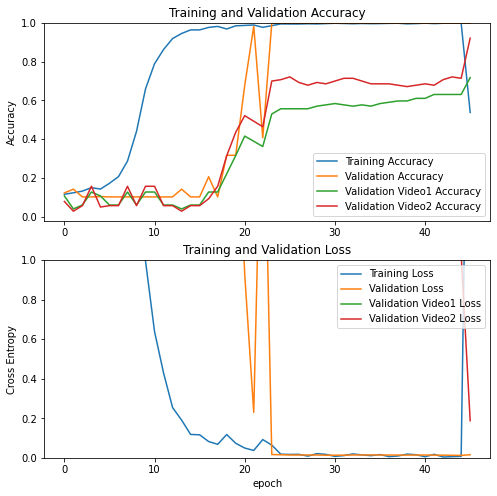

In [ ]:
acc_history_total = []
loss_history_total = []
val_acc_history_total = []
val_loss_history_total = []

for histories in history_book:
    acc = histories.history['accuracy']
    val_acc = histories.history['val_accuracy']  
    loss = histories.history['loss']
    val_loss = histories.history['val_loss']
    for vals in acc:
      acc_history_total.append(vals)
    for vals in val_acc:
      val_acc_history_total.append(vals)
    for vals in val_loss:
      val_loss_history_total.append(vals)
    for vals in loss:
      loss_history_total.append(vals)
 

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history_total, label='Training Accuracy')
plt.plot(val_acc_history_total, label='Validation Accuracy')
plt.plot(history_two['a1'], label='Validation Video1 Accuracy')
plt.plot(history_two['a2'], label='Validation Video2 Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history_total, label='Training Loss')
plt.plot(val_loss_history_total, label='Validation Loss')
plt.plot(history_two['l1'], label='Validation Video1 Loss')
plt.plot(history_two['l2'], label='Validation Video2 Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Let's take a look at how the network reasons:
1. Pick a random unseen photo from the dataset
2. Evaluate it
3. Plot a bar graph to see it can reason correctly 

(10, 48, 48, 1)
(48, 48, 1)
(10, 9)
BC


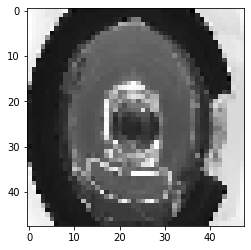

[[9.2687982e-01 6.2418375e-02 2.3825318e-03 6.5350912e-05 5.8151147e-04
  4.2187045e-03 4.5673791e-04 2.2284971e-03 7.6847844e-04]]
[0]


<BarContainer object of 9 artists>

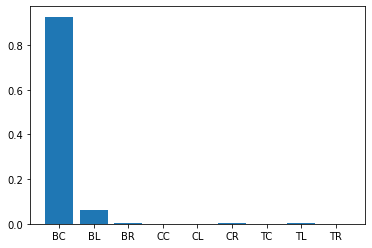

In [ ]:
import random

nextbatch = ez_val_ds.next()
print(nextbatch[0].shape)
print(nextbatch[0][0].shape)
print(nextbatch[1].shape)
images = nextbatch[0]
labels = nextbatch[1]
i = random.randint(0,len(images)-1)
image = images[i]
plt.imshow(image[:,:,0], cmap='gray')
image = np.expand_dims(image, axis=0)
label = labels[i].argmax()  # categorical from one-hot-encoding

predictions = model.predict(image)
   

print(classnames[label])
plt.show()
print(predictions)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
plt.bar(classnames,predictions.reshape(-1))






#['BC', 'BL', 'BR', 'CC', 'CL', 'CR', 'TC', 'TL', 'TR']


# Model discretization

In [ ]:
print(round(val_train_ds.n/BATCH_SIZE))
def representative_dataset():
  for _ in range(round(val_train_ds.n/BATCH_SIZE)):
    batch = val_train_ds.next()
    yield [batch[0]]

# Convert the tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('/content/gdrive/MyDrive/Visiope Workspace/models/'+modelname+'_quantized3.tflite', 'wb') as f:
  f.write(tflite_quant_model)

58
INFO:tensorflow:Assets written to: /tmp/tmp66d0tb18/assets


INFO:tensorflow:Assets written to: /tmp/tmp66d0tb18/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Test the quantized network, NOT WORKING

In [ ]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path='/content/gdrive/MyDrive/Visiope Workspace/models/'+modelname+'.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


# Resize input and output tensors to handle batch of 32 images
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (BATCH_SIZE, IMG_DIM, IMG_DIM, 1))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (BATCH_SIZE, 9))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter.set_tensor(input_details[0]['index'], val_train_ds)

tflite_interpreter.invoke()

tflite_q_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

## Tested quantized network result visualization

In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization
import pandas as pd
tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = classnames

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

# Working test for the output of the openmv evaluation test

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Nuovo documento di testo (3).txt to Nuovo documento di testo (3).txt


EOF
average delay: 85.92405063291139
sample evaluated: 79
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 6, 3, 6, 5, 3, 5, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 7, 5, 5, 5, 5, 8, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8]
              precision    recall  f1-score   support

          BC       1.00      0.50      0.67        10
          BL       0.46      1.00      0.63         6
          BR       1.00      0.89      0.94         9
          CC       1.00      0.50      0.67        10
          CL       1.00      0.86      0.92         7
          CR       0.62      0.83      0.71         6
          TC       0.83      1.00      0.91        10
          TL       0.91      1.00      

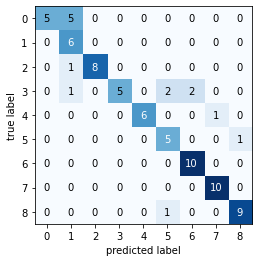

In [ ]:
import ast

def plotMatQuant(true_classes,predicted_classes):
  global classnames
  print(true_classes)
  print(predicted_classes)
  report = classification_report(true_classes, predicted_classes, target_names=classnames)
  print(report) 
  conf = confusion_matrix(true_classes, predicted_classes)
  print(conf)
  plot_confusion_matrix(conf)

y_pred = []
ori_tags = []
delay_median = 0
sample_count = 0



with open(list(uploaded.keys())[0], "r") as log:
  while(True):
    sample_count += 1
    filename = log.readline()
    if(filename == "" or filename == None):
      print("EOF")
      break
    filename = filename.replace("\n","")
    
    originalclass = log.readline()
    originalclass = originalclass.replace("\n","")
    originalclass = classnames.index(originalclass)
    ori_tags.append(originalclass)

    predictions = log.readline()
    predictions = predictions.replace("\n","")
    predictions = ast.literal_eval(predictions)
    predictedclass = np.argmax(predictions)
    y_pred.append(predictedclass)

    _ = log.readline()

    delay = log.readline()
    delay = delay.replace("\n","")
    delay = delay.replace("ms","")
    delay = ast.literal_eval(delay)
    delay_median += delay
  delay_median = delay_median / sample_count
  print("average delay:", delay_median)
  print("sample evaluated:", sample_count)
  plotMatQuant(ori_tags,y_pred)




